In [509]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#import language detector
from langdetect import detect
from googletrans import Translator
import re

# import libraries for text analysis
import nltk
from nltk import word_tokenize
# nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# import ml libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import brier_score_loss
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# import joblib to save ML Model
import joblib

## Build Functions for Text Processing

In [510]:
# text preprocessing

# create function for cleaning the text

# parts of speech tagging
def get_wordnet_pos(pos_tagger):
    if pos_tagger.startswith('J'):
        return wordnet.ADJ
    elif pos_tagger.startswith('V'):
        return wordnet.VERB
    elif pos_tagger.startswith('N'):
        return wordnet.NOUN
    elif pos_tagger.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Use NOUN as the default tag


def text_processing(review):
    translator = Translator()
    if detect(review) != "en":
        review = translator.translate(review, dest="en").text
    
    # change all reviews into lower case
    review = review.lower()
    
    #remove all new line and tab character, as well as split words joined with hyphen into two(2)
    review = review.replace("\n", " ").replace("\t", " ").replace("-", " ").replace("show", "")
    
    #remove all punctuations
    review = re.sub(r'[^\w\s]', ' ', review)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    
    #tokenize text
    tokens = word_tokenize(review)
    tokens = [token for token in tokens if token not in stop_words]
    
    #parts of speech tagging
    pos_tags = nltk.pos_tag(tokens)
    
    #lemmatize texts
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, pos in pos_tags:
        wordnet_tag = get_wordnet_pos(pos)
        lem_word = lemmatizer.lemmatize(word, pos=wordnet_tag)
        lemmatized_words.append(lem_word)
    
    processed_review = " ".join(lemmatized_words)
       
    return processed_review

# build an iterable collection of strings required for TfidfVectorizer in spam_detector_pipeline
def text_preprocessing(rev):
    # function only takes a string or list, dataframe or series of strings
    
    # return a list of clean values for string argument. This is because the TfidfVectorizer
    list_ = []
    
    if type(rev) == str:
        list_ = [text_processing(rev)]
    
    else:
        list_ = [text_processing(i) for i in rev]
    
    return list_

## Perform Manual Labelling
- Select 30 reviews from 3 books for manual labelling

### Book 1

In [511]:
url_book1 = "https://drive.google.com/file/d/1av14zclHw6vxzKlK9y9wf7jFHxK7ZhzO/view?usp=share_link"
file_path_book1 = "https://drive.google.com/uc?id=" + url_book1.split('/')[-2]
book1 = pd.read_csv(file_path_book1).head(30)

In [512]:
# manual labelling for book 1
label_book1 = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
book1['spam'] = label_book1

df_1 = book1[['Review', 'spam']]

### Book 2

In [513]:
url_book2 = "https://drive.google.com/file/d/14t71wvJDq0AIhIKBmc6OG6BhgRxZJCFC/view?usp=share_link"
file_path_book2 = "https://drive.google.com/uc?id=" + url_book2.split('/')[-2]
book2 = pd.read_csv(file_path_book2).head(30)

In [514]:
# remove reviews that couldn't be translated using google translator api
index_ = [8, 9, 24]
book2.drop(index_, axis = 0, inplace=True)

# labels
label_book2 = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]
book2["spam"] = label_book2

df_2 = book2[['Review', 'spam']]

### Book 3

In [515]:
url_book3 = "https://drive.google.com/file/d/19pqmhEu-aIa5cjMfYkCjtpdSCWgfhm1z/view?usp=share_link"
file_path_book3 = "https://drive.google.com/uc?id=" + url_book3.split('/')[-2]
book3 = pd.read_csv(file_path_book3).head(30)

In [516]:
label_book3 = [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
book3["spam"] = label_book3

df_3 = book3[['Review', 'spam']]

### sample data

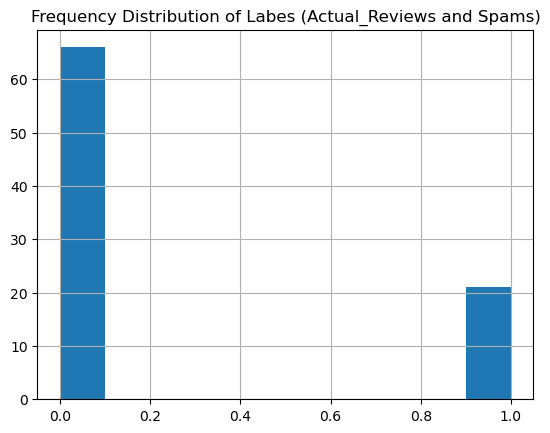

In [517]:
sample_data = pd.concat([df_1, df_2, df_3], axis = 0).sample(frac=1, random_state = 42)

# plot histogram to see distribution of review labels
sample_data.hist()
plt.title('Frequency Distribution of Labes (Actual_Reviews and Spams)')
plt.show()

## Analysis

In [518]:
# drop na values in sample_data
sample_data.dropna(axis=0, inplace=True)

reviews = sample_data['Review']
label = sample_data['spam']

# clean_reviews
reviews_clean = reviews.apply(lambda x: text_processing(x))

# vectorize clean_reviews
vectorizer_ = TfidfVectorizer()
reviews_vector = vectorizer_.fit_transform(reviews_clean)
reviews_vector.shape

(86, 6065)

### Carry out dimensionality reduction using PCA to avoid overfitting

In [519]:
# create pca object
pca_ = PCA()

# determine the number of components to retain- # fit the pca
pca_.fit(reviews_vector.toarray())

# obtain eigenvalue
explained_variance = pca_.explained_variance_

**Plot Screeplot**

Mean EigenValue: 0.011
Maximum EigenValue: 0.030


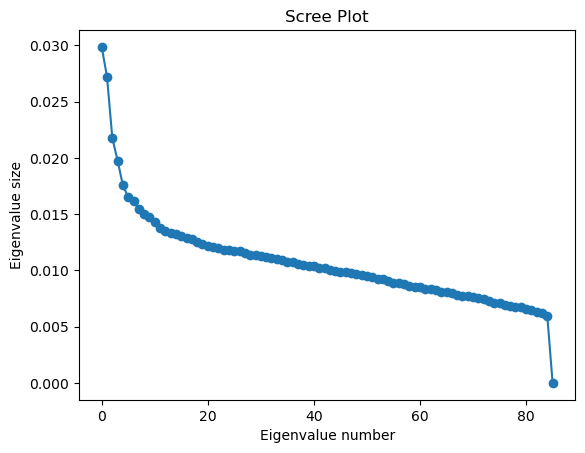

In [520]:
plt.plot(explained_variance, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

print("Mean EigenValue: {:.3f}".format(explained_variance.mean()))
print("Maximum EigenValue: {:.3f}".format(max(explained_variance)))

**Maximum EigenValue < 1. Therefore Kaiser Rule can't be used**

Use number of principal components that explain 95% of the variance in the dataset

Number of Components to Retain: PCA(n_components=78)



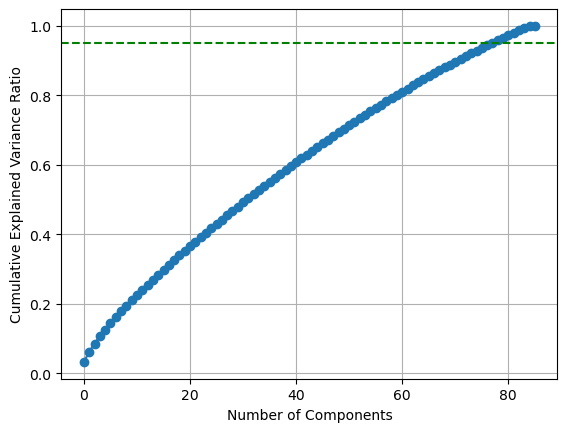

In [521]:
# find cumulative variance rato
cumulative_var_ratio = np.cumsum(pca_.explained_variance_ratio_)

# find the number of components needed to explain at least 95% of the variance
n_component = np.argmax(cumulative_var_ratio >= 0.95) + 1

pca_ = PCA(n_components = n_component)

# show result
print('Number of Components to Retain: {}\n'.format(pca_))

percentage_var_explained = 0.95 # Threshold of explained variance
n = np.min(reviews_vector.shape)

n_components = np.arange(0, n)

plt.plot(n_components, cumulative_var_ratio, marker='o')
plt.axhline(percentage_var_explained, color='g', linestyle='--')
plt.grid()
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

### ML Model Build - Supervised Learning

In [522]:
# dimensionality reduction
features = pca_.fit_transform(reviews_vector.toarray())

# check new dimension of features (reviews_vector)
features.shape

# create svc object
svc = SVC(kernel = 'linear', class_weight = 'balanced', probability = True)

# checking model performance using cross_val_score
performance_accuracy = cross_val_score(svc, features, label, scoring = 'accuracy', cv=5)
performance_f1 = cross_val_score(svc, features, label, scoring = 'f1', cv=5)

# print results:
print('Model Performance in terms of Accuracy_Score: {:.2f}'.format(performance_accuracy.mean()))
print('Accuracy for each Split: {}\n'.format(performance_accuracy))
print('Model Performance in terms of Accuracy_Score: {:.2f}'.format(performance_f1.mean()))
print('f1_score for each Split: {}'.format(performance_f1))

Model Performance in terms of Accuracy_Score: 0.80
Accuracy for each Split: [0.72222222 0.88235294 0.88235294 0.76470588 0.76470588]

Model Performance in terms of Accuracy_Score: 0.27
f1_score for each Split: [0.         0.66666667 0.66666667 0.         0.        ]


#### Check Model Calibration

In [523]:
# split data into train set and test set
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.3, shuffle=True, random_state=42, stratify=label)

# check fequency distribution of labels each stored variable
def frequency_check(data):
    class_count = np.bincount(data)
    freq_check = class_count[1]/np.sum(class_count)
    return freq_check

frq_check = pd.DataFrame([round(frequency_check(label),2), round(frequency_check(y_train), 2), round(frequency_check(y_test), 2)],
                       index = ['label', 'y_train', 'y_test']).transpose()

frq_check

,label,y_train,y_test
0,0.24,0.25,0.23


#### Model Fit and Prediction for Brier Score Determination

In [524]:
model = svc.fit(x_train, y_train)

spam_pred_probability = model.predict_proba(x_test)

# calibration check using brier_score_loss
brier_score = brier_score_loss(y_test, spam_pred_probability[:, 1])

# print result
print('Brier Score for the SVC: {:.3f}'.format(brier_score))

Brier Score for the SVC: 0.178


Observation: 
- Brier score close to zero, indicating good caliberation of predicted probabilities and may be indicative of true probabilities of each class

### Semi-supervised learning
- Build semi-supervised classifier from supervised classifier

In [525]:
# create copy of sample_data to be used to test model accuracy
sample_copy = sample_data.copy()

feature = pca_.transform(vectorizer_.transform(text_preprocessing(sample_copy['Review'])).toarray())
label_ = sample_copy['spam']

# randomize label to create a set of unlabeled data
rng = np.random.RandomState(42)
unlableled_datapoints = rng.rand(label_.shape[0]) < 0.3
label_[unlableled_datapoints] = -1

# check label distribution
num_unlabeled_data = list(label_.value_counts())[0]/np.sum(list(label_.value_counts()))
print('Percentage of Unlabeled Data: {}'.format(round(num_unlabeled_data, 3)))

Percentage of Unlabeled Data: 0.5


/var/folders/l0/vl1htxz9567gndxkbh7r1ld40000gn/T/ipykernel_14252/3769862873.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_[unlableled_datapoints] = -1


In [526]:
# create SelfTrainingClassifier object and classifier(SVC) object
svc_ = SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
stc = SelfTrainingClassifier(svc_)

# fit SelfTrainingClassifier
stc.fit(feature, label_)

# predict label
label_prediction = stc.predict(feature)

# model performance
f1_score_stc = f1_score(label, label_prediction)
acc_score_stc = accuracy_score(label, label_prediction)

# print_result
print('F1 Score of SelfTrainingClassifier: {:.3f}'.format(f1_score_stc))
print('Accuracy Score of SelfTrainingClassifier: {:.3f}'.format(acc_score_stc))

F1 Score of SelfTrainingClassifier: 0.727
Accuracy Score of SelfTrainingClassifier: 0.895


### Build Supervised Classifier Using KFold and select best model

- #### Determining number of components to retain from train_set

Number of Components to Retain: PCA(n_components=59)



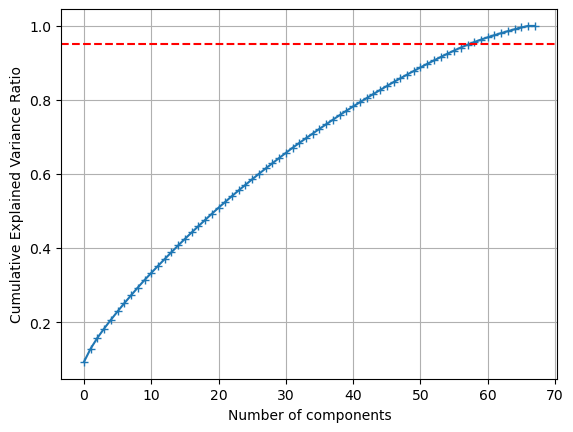

In [527]:
sample = sample_data.copy().sample(frac=1, random_state=42, ignore_index=True)

reviews = sample['Review']
label = sample['spam']

pca = PCA()

# split data into train_test_split
x_train, x_test, y_train, y_test = train_test_split(reviews, label, test_size = 0.2, shuffle=True, random_state=42, stratify=label)

# fit vectorizer on x_train
X_train = vectorizer.fit_transform(x_train)

# fit pca
pca.fit(X_train.toarray())

# retain number of components that explains at least 95% of the variance in the dataset
# find cumulative variance rato
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)

# find the number of components needed to explain at least 95% of the variance
n_component = np.argmax(cumulative_var_ratio >= 0.95) + 1

# create new PCA object
pca = PCA(n_components = n_component)

# show result
print('Number of Components to Retain: {}\n'.format(pca))

percentage_var_explained = 0.95 # Threshold of explained variance
n = np.min(X_train.shape)

n_components = np.arange(0, n)

plt.plot(n_components, cumulative_var_ratio, marker='+')
plt.axhline(percentage_var_explained, color='r', linestyle='--')
plt.grid()
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [528]:
# initialize new classifier object
svc = SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
vectorizer = TfidfVectorizer()

# create empty arrays to store models and performance metrics for each iteration in Kfold
model_ = []
f1_score_ = []
accuracy_score_ = []
confusion_matrix_ = []

# split the data into 10 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_data, test_data) in enumerate(kfold.split(reviews, label)):
    # split the data into train_test_split
    x_train, y_train = reviews[train_data], label[train_data]
    x_test, y_test = reviews[test_data], label[test_data]
    
    # vectorize X_train and X_test
    X_train = vectorizer.fit_transform(x_train)
    X_test = vectorizer.transform(x_test)
    
    # transform using PCA object defined above
    X_train_pca = pca.fit_transform(X_train.toarray())
    X_test_pca = pca.transform(X_test.toarray())
    
    # fit the filter containing LogisticRegression as the classifier
    model = svc.fit(X_train_pca, y_train)
    
    # append model into model_
    model_.append(model)
    
    # model_prediction
    prediction = model.predict(X_test_pca)
    
    # accuracy_score check for each model
    acc_check = round(accuracy_score(y_test, prediction), 2) # round to 2 decimal places
    accuracy_score_.append(acc_check)
    
    # f1_score check for each model
    f_score = round(f1_score(y_test, prediction),2) # round to 2 decimal places
    f1_score_.append(f_score)
    
    # confusion_matrix for each model
    conf_mat = confusion_matrix(y_test, prediction)
    confusion_matrix_.append(conf_mat)

# print result
print(f"Index of best model using f1_score: Model_{np.argmax(f1_score_)}")
print(f"Index of best model using accuracy_score: Model_{np.argmax(accuracy_score_)}")

Index of best model using f1_score: Model_1
Index of best model using accuracy_score: Model_1


In [529]:
performance_df = pd.DataFrame([accuracy_score_, f1_score_], index = ['accuracy_score', 'f1_score']).transpose()
performance_df

,accuracy_score,f1_score
0,0.72,0.29
1,0.94,0.80
2,0.82,0.40
3,0.76,0.00
4,0.65,0.25


## Model Comparison and Selection - SelfTrainingClassifier(svc) and SVC(K Fold Best Model)
- Create Pipelines for Models Built to Carry Out Random Test (tradeoff determinant)
- Select better model based on the tradeoff determinant (Random Test)

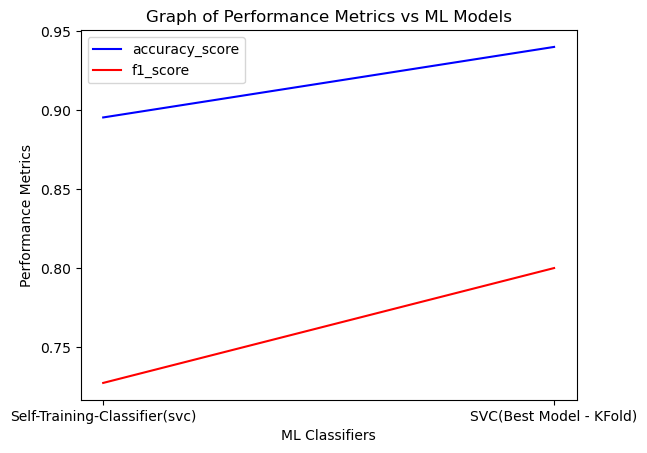

In [530]:
# Model Comparism
classifiers = ['Self-Training-Classifier(svc)', 'SVC(Best Model - KFold)']
accuracy_score_perf = [acc_score_stc, accuracy_score_[1]]
f1_score_perf = [f1_score_stc, f1_score_[1]]

# plot reults
fig, ax = plt.subplots()

# accuracy_score_plot
ax.plot(classifiers, accuracy_score_perf, color = 'blue', label='accuracy_score')

# f1_score_plot
ax.plot(classifiers, f1_score_perf, color = 'red', label='f1_score')

# graph formatting
ax.set_xlabel('ML Classifiers')
ax.set_ylabel('Performance Metrics')
ax.set_title('Graph of Performance Metrics vs ML Models')
ax.legend()
plt.show()

**Observation:**
- Best Supervised ML Model obtained through KFold outperforms Semi_Supervised ML Model.

**Caveat:**
- The size of the sample used is relatively small. Hence there is not enough datapoints for both models to learn the relationships in the dataset.
- Using F1_score as the performance metric for the supervised learning and the results obtained from the KFold, there could be possible overfitting in the selected model due to the inconsistency in the f1_score results of the supervised classifier for all iterations.

**Tradeoff:**
- Use both models to predict a random sentence that's most likely spam and select model with accurate prediction

In [531]:
def sparse_to_dense(vector):
    return vector.toarray()

In [532]:
stc_predictor_pipeline = make_pipeline(FunctionTransformer(text_preprocessing), vectorizer_, FunctionTransformer(sparse_to_dense), pca_, stc)
svc_predictor_pipeline = make_pipeline(FunctionTransformer(text_preprocessing), vectorizer, FunctionTransformer(sparse_to_dense), pca, model_[1])

In [533]:
# Random Test
string = 'Head on to my youtube page for more interesting contents! visit my link @ youtube.com/EMSE_6586/best_class'

# predict if spam or not
stc_predictor_pipeline.predict(string), svc_predictor_pipeline.predict(string)

(array([0]), array([1]))

Supervised ML Model Performed better than Semi_Supervised Model in Random Test

In [534]:
# save selected model:
joblib.dump(svc_predictor_pipeline, 'spam_detector.joblib')

['spam_detector.joblib']